# Fine-tuning

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kluster-ai/klusterai-cookbook/blob/main/examples/.ipynb)

## Setting up your environment

### API key configuration
To get started with this tutorial, you'll need a kluster.ai API key. If you don't have one yet, follow these steps:
1. Visit the <a href="https://platform.kluster.ai/signup" target="_blank">kluster.ai</a> to create an account.
2. Generate your API key

Once you have your API key, we'll use it to authenticate our requests to the kluster.ai API.

### Important note
Keep your API key secure and never share it publicly. In this notebook, we'll use Python's getpass module to safely input the key.

In [1]:
from getpass import getpass
# Enter you personal kluster.ai API key (make sure in advance it has no blank spaces)
api_key = getpass("Enter your kluster.ai API key: ")

Enter your kluster.ai API key:  ········


In [2]:
%pip install -q OpenAI

Note: you may need to restart the kernel to use updated packages.


In [3]:
import urllib.request
import pandas as pd
import numpy as np
from openai import OpenAI
import time
import json
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
import os

pd.set_option('display.max_columns', 1000, 'display.width', 1000, 'display.max_rows',1000, 'display.max_colwidth', 500)

In [4]:
# Set up the client
client_prod = OpenAI(
    base_url="https://api.kluster.ai/v1",
    api_key=api_key,
)

In [5]:
api_key_stg = os.getenv("KLUSTER_API_KEY_STG")
base_url = os.getenv("KLUSTER_BASE_URL", "https://api-r.klusterai.dev/v1")

if not api_key_stg:
    raise ValueError("KLUSTER_API_KEY environment variable is not set")

In [6]:
client_stg = OpenAI(
    api_key=api_key_stg,
    base_url=base_url
)

## Building our evaluation pipeline

### Understanding the helper functions
In this section, we'll create several utility functions that will help us:
1. Prepare our data for batch processing
2. Send requests to the kluster.ai API
3. Monitor the progress of our evaluation
4. Collect and analyze results

These functions will make our evaluation process more efficient and organized. Let's go through each one and understand its purpose.

1. `create_tasks()` - formats our data for the API
2. `save_tasks()` - prepares batch files for processing
3. `monitor_job_status()` - tracks evaluation progress
4. `get_results()` - collects and processes model outputs

## Creating and managing batch files

### What is a batch file?
A batch file in our context is a collection of requests that we'll send to our models for evaluation. Think of it as a organized list of tasks we want our models to complete.

### Step-by-Step process
1. **Creating tasks** - we'll convert each movie description into a format LLMs can process
2. **Organizing data** -we'll add necessary metadata and instructions for each task
3. **Saving files** - we'll store these tasks in a structured format (JSONL) for processing

### Understanding the code
Let's break down the key components of our batch file creation:
- `custom_id` - helps us track individual requests
- `system_prompt` - provides instructions to the model
- `content` - the actual text we want to classify

This structured approach allows us to efficiently process multiple requests in parallel.

In [7]:
def create_tasks(df, task_type, system_prompt, model, content_column):
    tasks = []
    for index, row in df.iterrows():
        content = row[content_column]
        
        task = {
            "custom_id": f"{task_type}-{index}",
            "method": "POST",
            "url": "/v1/chat/completions",
            "body": {
                "model": model,
                "temperature": 0,
                "max_completion_tokens": 100,
                "messages": [
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": content},
                ],
            }
        }
        tasks.append(task)
    return tasks

def save_tasks(tasks, task_type):
    filename = f"batch_tasks_{task_type}.jsonl"
    with open(filename, 'w') as file:
        for task in tasks:
            file.write(json.dumps(task) + '\n')
    return filename

## Uploading files to kluster.ai

### The upload process
Now that we've prepared our batch files, we'll upload them to the <a href="https://platform.kluster.ai/" target="_blank">kluster.ai</a>  platform for batch inference. This step is crucial for:
1. Getting our data to the models
2. Setting up the processing queue
3. Preparing for inference

### What happens next?
After upload:
1. The platform queues our requests
2. Models process them efficiently
3. Results are made available for collection

In [8]:
def create_batch_job(file_name, client):
    print(f"Creating batch job for {file_name}")
    batch_file = client.files.create(
        file=open(file_name, "rb"),
        purpose="batch"
    )

    batch_job = client.batches.create(
        input_file_id=batch_file.id,
        endpoint="/v1/chat/completions",
        completion_window="24h"
    )

    return batch_job

#### Check job progress

 This function provides real-time monitoring of batch job progress:
 - Continuously checks job status via the kluster.ai API
- Displays current completion count (completed/total requests)
- Updates status every 10 seconds until job is finished
- Automatically clears previous output for clean progress tracking

In [9]:
def parse_json_objects(data_string):
    if isinstance(data_string, bytes):
        data_string = data_string.decode('utf-8')

    json_strings = data_string.strip().split('\n')
    json_objects = []

    for json_str in json_strings:
        try:
            json_obj = json.loads(json_str)
            json_objects.append(json_obj)
        except json.JSONDecodeError as e:
            print(f"Error parsing JSON: {e}")

    return json_objects

def monitor_job_status(client, job_id, task_type):
    all_completed = False

    while not all_completed:
        all_completed = True
        output_lines = []

        updated_job = client.batches.retrieve(job_id)

        if updated_job.status.lower() != "completed":
            all_completed = False
            completed = updated_job.request_counts.completed
            total = updated_job.request_counts.total
            output_lines.append(f"{task_type.capitalize()} job status: {updated_job.status} - Progress: {completed}/{total}")
        else:
            output_lines.append(f"{task_type.capitalize()} job completed!")

        # Clear the output and display updated status
        clear_output(wait=True)
        for line in output_lines:
            display(line)

        if not all_completed:
            time.sleep(10)

### Collecting and processing results

#### Understanding the format
 The get_results() function below:
 1. Retrieves the completed batch job results
 2. Extracts the model's response content from each result
 3. Returns a list of all model responses



In [10]:
def get_results(client, job_id):
    batch_job = client.batches.retrieve(job_id)
    result_file_id = batch_job.output_file_id
    result = client.files.content(result_file_id).content
    results = parse_json_objects(result)
    answers = []
    
    for res in results:
        result = res['response']['body']['choices'][0]['message']['content']
        answers.append(result)
    
    return answers

## Prepare a real dataset for batch inference

Now that we have covered the core general functions and workflow used for batch inference, in this guide, we’ll be using the IMDb Top 1000 dataset, which contains information about top-rated movies, including their descriptions and genres. Let's download it and see what it looks like.

In [11]:
# IMDB Top 1000 dataset:
url = "https://raw.githubusercontent.com/kluster-ai/klusterai-cookbook/refs/heads/main/data/imdb_top_1000.csv"
urllib.request.urlretrieve(url,filename='imdb_top_1000.csv')

# Load and process the dataset based on URL content
df = pd.read_csv('imdb_top_1000.csv', usecols=['Series_Title', 'Overview', 'Genre'])
df.head(3)

Series_Title                 Genre                                                                                                                                                                                       Overview
0  The Shawshank Redemption                 Drama                                                                         Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.
1             The Godfather          Crime, Drama                                                                                 An organized crime dynasty's aging patriarch transfers control of his clandestine empire to his reluctant son.
2           The Dark Knight  Action, Crime, Drama  When the menace known as the Joker wreaks havoc and chaos on the people of Gotham, Batman must accept one of the greatest psychological and physical tests of his ability to fight injustice.

In [12]:
df['single_genre'] = df['Genre'].str.split(',').str[0]

As you may notice, each movie already has a annoated label, and in some cases, there may be more than one label for each movie. For the purpose of this notebook, we will ask the LLM to identify just one genre. If the predicted genre matches at least one of the genres listed in the dataset’s genre column (our ground truth), we will consider the prediction to be correct. By using some ground truth annotated data, we can calculate the accuracy and measure how well the LLM performed.

## Performing batch inference

With LLMs it is really important to write a good prompt, including the system prompt. Below you can see our example instruction for the LLM. This is something you should experiment with and see how it changes the performance!

In [13]:
SYSTEM_PROMPT = '''
    You are a helpful assitant that classifies movie genres based on the movie description. Choose one of the following options: 
    Action, Adventure, Animation, Biography, Comedy, Crime, Drama, Family, Fantasy, Film-Noir, History, Horror, Music, Musical, Mystery, Romance, Sci-Fi, Sport, Thriller, War, Western.
    Provide your response as a single word with the matching genre. Don't include punctuation.
    '''

Now that the prompt is defined, it’s time to execute the code and run the classification task for each model. In this step, we loop through the list of models, creating the requests and batch jobs, monitoring progress and retrieving the results.


In [14]:
# Define models
models = {
        '8B':"klusterai/Meta-Llama-3.1-8B-Instruct-Turbo",
        #'70B':"klusterai/Meta-Llama-3.3-70B-Instruct-Turbo",
        #'405B':"klusterai/Meta-Llama-3.1-405B-Instruct-Turbo",
        }

# Process each model: create tasks, run jobs, and get results
for name, model in models.items():
    task_list = create_tasks(df, task_type='assistant', system_prompt=SYSTEM_PROMPT, model=model, content_column='Overview')
    filename = save_tasks(task_list, task_type='assistant')
    job = create_batch_job(filename, client=client_prod)
    monitor_job_status(client=client_prod, job_id=job.id, task_type=f'{name} model')
    df[f'answer_8b'] = get_results(client=client_prod, job_id=job.id)

'8b model job completed!'

In [15]:
df.tail(100)

Series_Title                         Genre                                                                                                                                                                                                                                                                                                                   Overview single_genre        answer_8b
900                                    Serbuan maut              Action, Thriller                                                                                                                                                                                                                 A S.W.A.T. team becomes trapped in a tenement run by a ruthless mobster and his army of killers and thugs.       Action           Action
901                                    End of Watch          Action, Crime, Drama                                                                                                                        Shot documentary-style, this film follows the daily grind of two young police officers in LA who are partners and friends, and what happens when they meet criminal forces greater than themselves.       Action            Crime
902                         Kari-gurashi no Arietti  Animation, Adventure, Family                                                                                                The Clock family are four-inch-tall people who live anonymously in another family's residence, borrowing simple items to make their home. Life changes for the Clocks when their teenage daughter, Arrietty, is discovered.    Animation           Family
903                                  A Star Is Born         Drama, Music, Romance                                                                                                                                                                                                                A musician helps a young singer find fame as age and alcoholism send his own career into a downward spiral.        Drama            Drama
904                                       True Grit                Drama, Western                                                                                                                                                                                                                          A stubborn teenager enlists the help of a tough U.S. Marshal to track down her father's murderer.        Drama          Western
905                                          Hvnen                Drama, Romance                                                                                                                                                               The lives of two Danish families cross each other, and an extraordinary but risky friendship comes into bud. But loneliness, frailty and sorrow lie in wait.        Drama            Drama
906                                   Despicable Me      Animation, Comedy, Crime                                                                                                                                                                         When a criminal mastermind uses a trio of orphan girls as pawns for a grand scheme, he finds their love is profoundly changing him for the better.    Animation          Romance
907                                           50/50        Comedy, Drama, Romance                                                                                                                                                                       Inspired by a true story, a comedy centered on a 27-year-old guy who learns of his cancer diagnosis and his subsequent struggle to beat the disease.       Comedy           Comedy
908                                        Kick-Ass         Action, Comedy, Crime                                                                                                                   

In [16]:
from sklearn.model_selection import train_test_split
# Split into train (80%) and test (20%) sets
train_df, test_df = train_test_split(df, test_size=0.9, random_state=42)

In [17]:
test_df.apply(lambda row: row[f'answer_8b'] in row['Genre'].split(', '), axis=1).mean()

0.75

In [18]:
len(train_df)

100

In [19]:
# Generate JSONLines file
with open("finetuning/data/movies.jsonl", "w") as f:
    for _, row in train_df.iterrows():
        # Create the message structure
        messages = {
            "messages": [
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": row['Overview']},
                {"role": "assistant", "content": row["single_genre"]}
            ]
        }
        # Write to the file as a single JSON object per line
        f.write(json.dumps(messages) + "\n")

# Finetuning

In [31]:
data_dir = 'finetuning/data/movies.jsonl'

with open(data_dir, 'rb') as file:
    upload_response = client_stg.files.create(
        file=file,
        purpose="fine-tune"
    )
    file_id = upload_response.id
    print(f"File uploaded successfully. File ID: {file_id}")

File uploaded successfully. File ID: 6786d821abc6a689e300d38b


In [36]:
job = client_stg.fine_tuning.jobs.create(
    training_file=file_id,
    model="klusterai/Meta-Llama-3.1-8B-Instruct-Turbo",
    #hyperparameters={
    #    "batch_size": 4,
    #    "n_epochs": 2,
    #    "learning_rate_multiplier": 1
    #}
)
print("\nFine-tuning job created:")
print(json.dumps(job.model_dump(), indent=2))


Fine-tuning job created:
{
  "id": "6786d913abc6a689e300d3cc",
  "created_at": 1736890643,
  "error": null,
  "fine_tuned_model": null,
  "finished_at": null,
  "hyperparameters": {
    "n_epochs": "auto",
    "batch_size": "auto",
    "learning_rate_multiplier": "auto"
  },
  "model": "klusterai/Meta-Llama-3.1-8B-Instruct-Turbo",
  "object": "fine_tuning.job",
  "organization_id": null,
  "result_files": [],
  "seed": null,
  "status": "queued",
  "trained_tokens": null,
  "training_file": "6786d821abc6a689e300d38b",
  "validation_file": null,
  "estimated_finish": null,
  "integrations": []
}


In [37]:
while True:
    job_status = client_stg.fine_tuning.jobs.retrieve(job.id)
    status = job_status.status
    print(f"\nCurrent status: {status}")
    
    events = client_stg.fine_tuning.jobs.list_events(job.id)
    events_list = [e.model_dump() for e in events]
    events_list.sort(key=lambda x: x['created_at'])
    print("\nJob events:")
    print(json.dumps(events_list, indent=2))
    
    if status in ["succeeded", "failed", "cancelled"]:
        break
    
    time.sleep(10)



Current status: running

Job events:
[
  {
    "id": "6786d913e2b1c043feaa8018",
    "created_at": 1736890643,
    "level": "info",
    "message": "Validating training file: 6786d821abc6a689e300d38b",
    "object": "fine_tuning.job.event",
    "data": {},
    "type": "message"
  },
  {
    "id": "6786d913abc6a689e300d3ce",
    "created_at": 1736890643,
    "level": "info",
    "message": "Created fine-tuning job: 6786d913abc6a689e300d3cc",
    "object": "fine_tuning.job.event",
    "data": {},
    "type": "message"
  },
  {
    "id": "6786d914e2b1c043feaa801d",
    "created_at": 1736890644,
    "level": "info",
    "message": "Files validated, moving job to queued state",
    "object": "fine_tuning.job.event",
    "data": {},
    "type": "message"
  }
]

Current status: running

Job events:
[
  {
    "id": "6786d913e2b1c043feaa8018",
    "created_at": 1736890643,
    "level": "info",
    "message": "Validating training file: 6786d821abc6a689e300d38b",
    "object": "fine_tuning.job.ev

In [40]:
fine_tuned_model = job_status.fine_tuned_model

In [41]:
job_status.fine_tuned_model

'ft:klusterai:Meta-Llama-3.1-8B-Instruct-Turbo:personal::88b3a922'

# Make a model predict:

In [21]:
SYSTEM_PROMPT = '''
    You are a helpful assitant that classifies movie genres based on the movie description. Choose one of the following options: 
    Action, Adventure, Animation, Biography, Comedy, Crime, Drama, Family, Fantasy, Film-Noir, History, Horror, Music, Musical, Mystery, Romance, Sci-Fi, Sport, Thriller, War, Western.
    Provide your response as a single word with the matching genre. Don't include punctuation.
    '''

In [41]:
task_list = create_tasks(test_df, task_type='assistant', system_prompt=SYSTEM_PROMPT, model=fine_tuned_model, content_column='Overview')
filename = save_tasks(task_list, task_type='assistant')
job = create_batch_job(filename, client=client_stg)
monitor_job_status(client=client_stg, job_id=job.id, task_type=f'ft model')
test_df[f'answer_ft_8b'] = get_results(client=client_stg, job_id=job.id)

'Ft model job completed!'

In [43]:
test_df.apply(lambda row: row[f'answer_ft_8b'] in row['Genre'].split(', '), axis=1).mean()

0.6455555555555555

In [44]:
test_df.apply(lambda row: row[f'answer_8b'] in row['Genre'].split(', '), axis=1).mean()

0.75

In [45]:
test_df.head(10)

Series_Title                         Genre                                                                                                                                                                                                                Overview single_genre  answer_8b answer_ft_8b
521                 Trois couleurs: Bleu         Drama, Music, Mystery                                                                                                                              A woman struggles to find a way to live her life after the death of her husband and child.        Drama      Drama        Drama
737  Captain America: The Winter Soldier     Action, Adventure, Sci-Fi  As Steve Rogers struggles to embrace his role in the modern world, he teams up with a fellow Avenger and S.H.I.E.L.D agent, Black Widow, to battle a new threat from history: an assassin known as the Winter Soldier.       Action     Action       Action
740                       Wreck-It Ralph  Animation, Adventure, Comedy                                                                               A video game villain wants to be a hero and sets out to fulfill his dream, but his quest brings havoc to the whole arcade where he lives.    Animation     Comedy    Animation
660                          The Sandlot         Comedy, Drama, Family                                                                          In the summer of 1962, a new kid in town is taken under the wing of a young baseball prodigy and his rowdy team, resulting in many adventures.       Comedy      Sport       Comedy
411                               Gandhi     Biography, Drama, History                                                                         The life of the lawyer who became the famed leader of the Indian revolts against the British rule through his philosophy of nonviolent protest.    Biography  Biography    Biography
678                         Evil Dead II       Action, Comedy, Fantasy                                                                     The lone survivor of an onslaught of flesh-possessing spirits holes up in a cabin with a group of strangers while the demons continue their attack.       Action     Horror       Horror
626                 Little Miss Sunshine                 Comedy, Drama                                                                                          A family determined to get their young daughter into the finals of a beauty pageant take a cross-country trip in their VW bus.       Comedy     Family       Comedy
513                      Children of Men      Adventure, Drama, Sci-Fi                                               In 2027, in a chaotic world in which women have become somehow infertile, a former activist agrees to help transport a miraculously pregnant woman to a sanctuary at sea.    Adventure      Drama        Drama
859                            Repulsion       Drama, Horror, Thriller                                                                                     A sex-repulsed woman who disapproves of her sister's boyfriend sinks into depression and has horrific visions of rape and violence.        Drama     Horror        Drama
136                             Drishyam         Crime, Drama, Mystery                                                                                Desperate measures are taken by a man who tries to save his family from the dark side of the law, after they commit an unexpected crime.        Crime      Crime        Crime

## Analyzing the Results

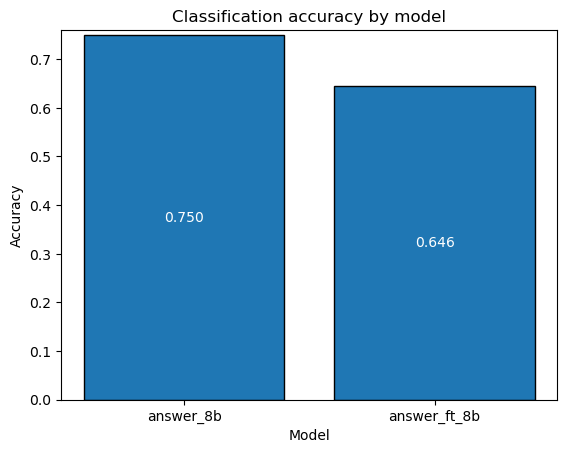

In [49]:
# Calculate accuracy for each model
accuracies = {}
for name in ['answer_8b','answer_ft_8b']:
    accuracy = test_df.apply(lambda row: row[name] in row['Genre'].split(', '), axis=1).mean()
    accuracies[name] = accuracy

# Create the bar plot
fig, ax = plt.subplots()
bars = ax.bar(accuracies.keys(), accuracies.values(), edgecolor='black')
ax.bar_label(bars, label_type='center', color='white', fmt="%.3f")
ax.set_ylim(0, max(accuracies.values())+ 0.01)
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')

ax.set_title('Classification accuracy by model')
plt.show()